## Week 06 Lab

### Modeling exponential growth of US population

The goal of this exerice is to find the parameters of an exponential fit of US population growth with time

$$ y = a_1 \exp(a_2t) $$

where $y$ is population and $t$ is time in years.

Data for this exercise is located in a text file at https://github.com/mlmldata2017/week06-uspopulation

This exercise is based on Chapter 38 of Shapiro, B. E. (2016) Scientific Computation: Python Hacking for Math Junkies, Sherwood Forest Publishing.

In [ ]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

First, read in the data and put into variables that are easy to remember and type.

In [6]:
df = pd.read_csv('data/week06_uspopulation/us-population.txt',header=2)
yr = df['YR']
pop = df['USPOP']

Since this example is focused on the US, create a new variable where the year is referenced to the founding of the US.

In [7]:
t = yr - 1776
logpop = np.log(pop)

#### Plotting the data

<IPython.core.display.Javascript object>


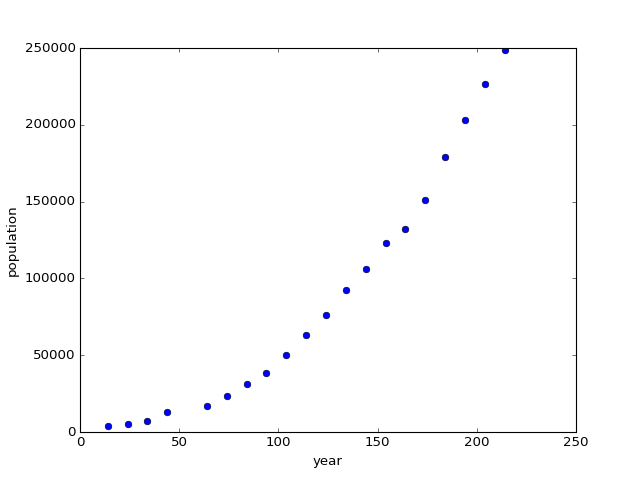

In [38]:
plt.figure()
plt.plot(t,pop,'o')
plt.xlabel('year')
plt.ylabel('population')

<IPython.core.display.Javascript object>


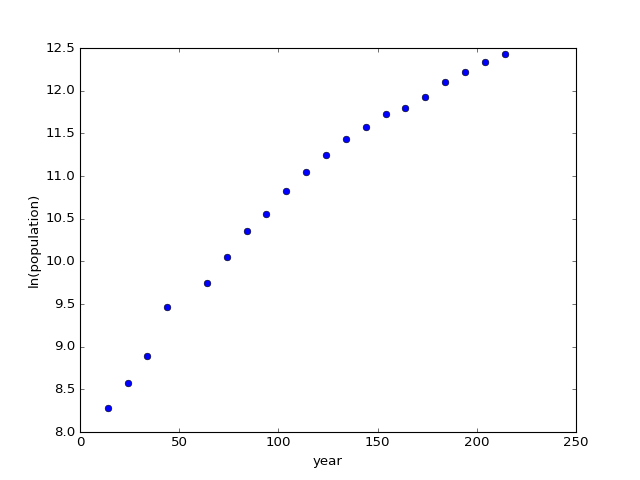

In [37]:
plt.figure()
plt.plot(t,logpop,'o')
plt.xlabel('year')
plt.ylabel('ln(population)')

##### Exercises:

* Estimate the parameters $a_1$ and $a_2$ is to performing a linear least-squares fit to the log-transformed data shown above.
* Plot the original data (not transformed) and the exponential fit using these parameters.

### Visualizing the cost function

An extremely inefficient way of optimizing the parameters would be to try every possible combination of parameters within some range. This is called the "brute force" method because it relies on computer power rather than intelligence.

Even though it is inefficient, it is a good way to visualize the cost function in two dimensions.

<IPython.core.display.Javascript object>


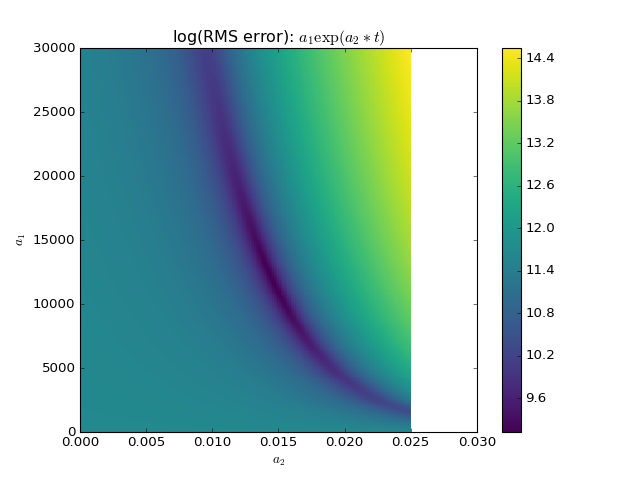

In [11]:
# plot the (square root of) the cost function 
# as a function of fit paramters
alla1 = np.linspace(0,3e4,200) 
alla2 = np.linspace(0,0.025,200)

# pre-allocate error matrix
rms = np.nan*np.ones([len(alla1),len(alla2)])

# nested for loop
# go through each combination of parameter pairs in that range
# 200 x 200 = 40000 values
for ii,a1 in enumerate(alla1):
    for jj,a2 in enumerate(alla2):
        popfit = a1*np.exp(a2*t)
        rms[ii,jj] = np.sqrt(np.mean((popfit-pop)**2))

plt.figure()
plt.pcolor(alla2,alla1,np.log(rms),cmap='viridis')
#plt.plot(slope,np.exp(intercept),'ro')
plt.colorbar()
plt.title('log(RMS error): $a_1\exp(a_2*t)$')
plt.xlabel('$a_2$')
plt.ylabel('$a_1$')

### Non-linear optimization

The first step in this process is to define the function that you want to fit to data.

In [12]:
def exponential_growth(x,a,b):
    '''computes f = a*exp(b*x)'''
    f = a*np.exp(b*x)
    return f

In [13]:
help(exponential_growth)

Help on function exponential_growth in module __main__:

exponential_growth(x, a, b)
    computes f = a*exp(b*x)



In [14]:
fvalues = exponential_growth(np.array([0,1]),10,1)
print(fvalues)

[ 10.          27.18281828]


The `scipy.optimize` library can be used to find the unknown coefficients. The `curve_fit` function is especially good at find the minima of cost functions. It needs to have 1) the function being fit (`exponential_growth1`) and 2) the data values (`t`,`pop`). It also really helps to have a good initial guess for the parameter values (`p0`).

In [15]:
from scipy.optimize import curve_fit
popt,pcov = curve_fit(exponential_growth,t,pop,p0=[6000,0.03])

The first variable in the output (`popt`) is the two coefficients that give the optimal fit to the data.

In [16]:
popt

array([  1.17678552e+04,   1.45465803e-02])

### Estimating error of coefficients

The second variable in the output (`pcov`) is the error covariance matrix.

In [17]:
pcov

array([[  1.59526049e+06,  -7.10599907e-01],
       [ -7.10599907e-01,   3.26096426e-07]])

The diagonal elements of the covariance matrix can be thought of as the variance that there would be in the coefficient if you resampled many times and repeated the fit procedure. This could be estimated from the data using subsets of the data.

The square root of the diagonals are called the _standard errors_ of the parameter estimates (e.g. $\sigma_a$ for parameter estimate $\hat{a}$). If you resampled many times, and the errors are normally distributed, then about 68% of the parameter estimates would fall in the interval $\hat{a}-\sigma_a < a < \hat{a}+\sigma_a$. Confidence intervals can be computed using the standard error and the t-statistic.

In [18]:
err = np.sqrt(np.diag(pcov))
print(err)

[  1.26303622e+03   5.71048533e-04]


The diagonals of the error covariance matrix decribe correlations that occur in estimates of the different parameters. For example, if you resample many times, does parameter $a$ usually increase when parameter $b$ increases. If so, this means that the parameters covary when resampling, and this would result in a positive error covariance term.

<IPython.core.display.Javascript object>


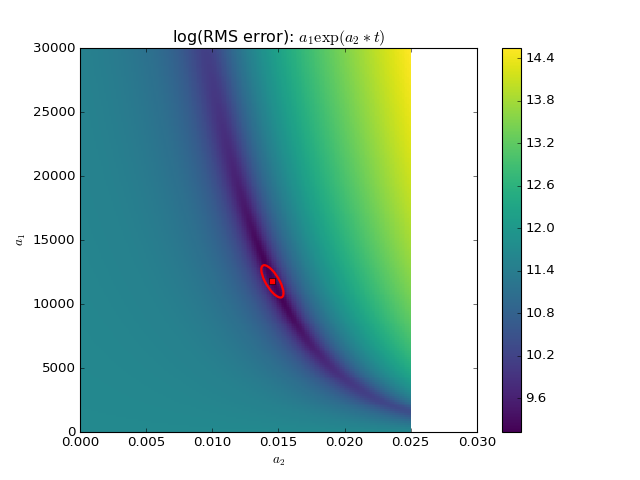

In [36]:
from matplotlib.patches import Ellipse

plt.figure()
plt.pcolor(alla2,alla1,np.log(rms),cmap='viridis')
plt.colorbar()
#plt.plot(slope,np.exp(intercept),'ro')
plt.plot(popt[1],popt[0],'rs')
plt.title('log(RMS error): $a_1\exp(a_2*t)$')
plt.xlabel('$a_2$')
plt.ylabel('$a_1$')

h, w = 2*err
theta = np.rad2deg(0.5*np.arctan(np.sqrt(pcov[1,0]/pcov[0,1]))*popt[1]/popt[0])
ell = Ellipse(xy=(popt[1],popt[0]),
              width=w, height=h,
              angle=theta, color='r',lw=2)
ell.set_facecolor('none')
plt.gca().add_artist(ell)

Plotting the parameter estimate on the map of the cost function shows that the nonlinear optimization procedure (square) succeeds in finding the minimum of the cost function, thus minimizing the sum of squared differences between the data values and corresponding model values.

The covariance matrix can be visualized with an ellipse in this map of the cost function. The height and width of the ellipse are determined by the standard errors of the coefficients. The orientation of the ellipse is determined by the off-diagonal elements of the covariance matrix.

### Excercises

* Use the optimization techniques described above to fit an exponential curve to the data from phytoplankton growth experiments in https://github.com/mlmldata2017/week06_growth_experiments
* Write a function that can be used to fit an exponential curve to any data set, and return error estimates of the coefficients.
* Plot the parameters obtained from the linear regression of the log-transformed data on the cost function map.